# EXPlain - Explainable Patent Learning for Artificial Intelligence
Juin/Juillet 2024, Mastercamp

## Etape 1: Préparation des données

### Installation des paquets requis & importation des librairies

In [ ]:
! pip install pandas tensorflow torch transformers scikit-learn keras openpyxl numpy keras_preprocessing tqdm nltk

In [ ]:
import os

MODEL_TYPE = 'model_1char_bert'

# Création du dossier s'il n'existe pas
if not os.path.exists(MODEL_TYPE):
    os.makedirs(MODEL_TYPE)

### Récupération des données (si pas de fichier data_cleaned)

Chargement du fichier local data.xlsx

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path

content_path = Path('content')

data = pd.read_excel('data.xlsx')

# Print first data value
data.head()

Nettoyage des données

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
import pandas as pd

def clean_data(data_var: pd.DataFrame):
    # Suppression des colonnes inutiles
    if 'Numéro de publication' in data_var.columns:
        data_var = data_var.drop(columns=['Numéro d\'application', 'Date d\'application', 'date de publication', 'Numero de publication', 'IPC'])

    # Séparation des valeurs de CPC (si pas une liste de valeurs)
    if 'CPC' in data_var.columns and data_var['CPC'].dtype != list:
        data_var['CPC'] = data_var['CPC'].apply(lambda x: re.sub(r'[\[\],]', '', x).split())

    # Suppression des tags HTML
    data_var['description'] = data_var['description'].str.lower().replace('<.*?>|<!--|-->|[^a-zA-Z0-9 ]| +', ' ', regex=True)
    data_var['claim'] = data_var['claim'].str.lower().replace('<.*?>|<!--|-->|[^a-zA-Z0-9 ]| +', ' ', regex=True)

    # Suppression des 'stop words'
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))
    data_var['description'] = data_var['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    data_var['claim'] = data_var['claim'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

    # Lemmatisation (racinisation des mots)
    nltk.download('wordnet')
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    data_var['description'] = data_var['description'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
    data_var['claim'] = data_var['claim'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))


# clean_data(data)

# data



Sauvegarde des données nettoyées dans un fichier

*(Cela nous évitera de les re-nettoyer à chaque lancement de programme)*

In [ ]:
data.to_excel('data_cleaned.xlsx', index=False)

## ⚠️ Etape 1 (2): Chargement des données déjà nettoyées

In [ ]:
import pandas as pd
import ast

def load_xlsx(name:str):
    dataload = pd.read_excel(name)
    if 'CPC' in dataload.columns:
        dataload['CPC'] = dataload['CPC'].apply(ast.literal_eval)
    return dataload

def load_csv(name:str):
    dataload = pd.read_csv(name)
    # if 'CPC' in dataload.columns:
    #     dataload['CPC'] = dataload['CPC'].apply(ast.literal_eval)
    return dataload

data = load_xlsx('data_cleaned.xlsx')

data

## Etape 2: Entrainement du modèle

Préparation des classes & données d'entrainement

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
from transformers import BertTokenizer, BertModel

def get_firstcpc(data:pd.DataFrame, char_amount):
    if 'CPC' in data.columns:
        data['FirstCPC'] = data['CPC'].apply(lambda x: list(set([cpc.replace("'", "")[:char_amount] for cpc in x])))

if MODEL_TYPE == 'model_3char_bert':
    get_firstcpc(data, 3)
elif MODEL_TYPE == 'model_1char_bert':
    get_firstcpc(data, 1)

# Binariser les labels
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(data['FirstCPC'])

# Diviser les données en train et test
X_train, X_test, y_train, y_test = train_test_split(data['description'], y, test_size=0.2, random_state=42)

# 2. Création des DataLoaders
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Créer la classe PatentDataset (qui nous permettra de créer les DataLoaders)
class PatentDataset(Dataset):
    def __init__(self, descriptions, claims, labels, tokenizer, max_len):
        self.descriptions = descriptions
        self.claims = claims
        self.labels = torch.tensor(labels, dtype=torch.float32)
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.descriptions)
    
    def __getitem__(self, idx):
        desc = str(self.descriptions.iloc[idx])
        claim = str(self.claims.iloc[idx])
        
        encoding_desc = self.tokenizer.encode_plus(
            desc,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        
        encoding_claim = self.tokenizer.encode_plus(
            claim,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        
        return {
            'input_ids_desc': encoding_desc['input_ids'].flatten(),
            'attention_mask_desc': encoding_desc['attention_mask'].flatten(),
            'input_ids_claim': encoding_claim['input_ids'].flatten(),
            'attention_mask_claim': encoding_claim['attention_mask'].flatten(),
            'labels': self.labels[idx]
        }


# Créer les DataLoaders
MAX_LEN = 512 # Taille maximale des séquences (Max 512 pour BERT)
BATCH_SIZE = 8 # Taille du batch

# Créer les datasets
train_dataset = PatentDataset(X_train, data.loc[X_train.index, 'claim'], y_train, tokenizer, MAX_LEN)
test_dataset = PatentDataset(X_test, data.loc[X_test.index, 'claim'], y_test, tokenizer, MAX_LEN)

# Créer les DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)


Sauvegarde des datasets (train et test)

In [ ]:
import pandas as pd

# Sauvegarder les données de test et de train en CSV
X_train.to_csv(f'{MODEL_TYPE}/X_train.csv', index=False)
X_test.to_csv(f'{MODEL_TYPE}/X_test.csv', index=False)
y_train = pd.DataFrame(y_train, columns=mlb.classes_)
y_test = pd.DataFrame(y_test, columns=mlb.classes_)
y_train.to_csv(f'{MODEL_TYPE}/y_train.csv', index=False)
y_test.to_csv(f'{MODEL_TYPE}/y_test.csv', index=False)

y_train.head()

# Sauvegarder les lignes de test et de train (pour pouvoir retrouver les données plus tard)
X_train_index_df = pd.DataFrame(X_train.index)
X_test_index_df = pd.DataFrame(X_test.index)

X_train_index_df.to_csv(f'{MODEL_TYPE}/X_train_index.csv', index=False)
X_test_index_df.to_csv(f'{MODEL_TYPE}/X_test_index.csv', index=False)


In [ ]:
# Charger les données de train et test depuis les fichiers CSV
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Extraire les descriptions, les revendications et les étiquettes
X_train = train_data['description']
X_test = test_data['description']
y_train = mlb.transform(train_data['FirstCPC'])
y_test = mlb.transform(test_data['FirstCPC'])
claims_train = train_data['claim']
claims_test = test_data['claim']


# Print CPCs
print(mlb.classes_[0])

# Créer les datasets
train_dataset = PatentDataset(X_train, claims_train, y_train, tokenizer, MAX_LEN)
test_dataset = PatentDataset(X_test, claims_test, y_test, tokenizer, MAX_LEN)

# Créer les DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)


Création de la classe PatentClassifier (qui nous permettra de créer le modèle de classification)

In [ ]:
import torch.nn as nn
import torch

torch.cuda.empty_cache()

class PatentClassifier(nn.Module):
    def __init__(self, n_classes, dropout_rate=0.5):
        super(PatentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.drop = nn.Dropout(p=dropout_rate)
        self.out = nn.Linear(self.bert.config.hidden_size * 2, n_classes)  # Multiply by 2 to concatenate desc and claim

    def forward(self, input_ids_desc, attention_mask_desc, input_ids_claim, attention_mask_claim):
        desc_outputs = self.bert(input_ids=input_ids_desc, attention_mask=attention_mask_desc)
        claim_outputs = self.bert(input_ids=input_ids_claim, attention_mask=attention_mask_claim)
        
        pooled_output_desc = desc_outputs[1]
        pooled_output_claim = claim_outputs[1]

        pooled_output = torch.cat((pooled_output_desc, pooled_output_claim), dim=1)
        
        output = self.drop(pooled_output)
        return self.out(output)

    
# Initialiser le modèle sur le GPU si disponible, CPU sinon
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instancier le modèle
model = PatentClassifier(n_classes=y_train.shape[1])
model = model.to(device)

Création de la fonction d'évaluation du modèle

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def eval_model(model, test_loader, mlb):
    model.eval()
    all_outputs = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids_desc = batch['input_ids_desc'].to(device)
            attention_mask_desc = batch['attention_mask_desc'].to(device)
            input_ids_claim = batch['input_ids_claim'].to(device)
            attention_mask_claim = batch['attention_mask_claim'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids_desc=input_ids_desc, attention_mask_desc=attention_mask_desc,
                            input_ids_claim=input_ids_claim, attention_mask_claim=attention_mask_claim)
            all_outputs.append(outputs)
            all_labels.append(labels)

    all_outputs = torch.cat(all_outputs)
    all_labels = torch.cat(all_labels)

    threshold = 0.5
    preds = (all_outputs > threshold).float()

    preds_np = preds.cpu().numpy()
    all_labels_np = all_labels.cpu().numpy()

    accuracy = accuracy_score(all_labels_np, preds_np)
    f1 = f1_score(all_labels_np, preds_np, average='micro')

    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")

    pred_labels = mlb.inverse_transform(preds_np)
    true_labels = mlb.inverse_transform(all_labels_np)

    for i, (true, pred) in enumerate(zip(true_labels, pred_labels)):
        print(f"Sample {i+1}:")
        print(f"  True labels: {true}")
        print(f"  Predicted labels: {pred}")


## --- Arrêt du programme (afin de sélectionner la prochaine étape) ---

In [ ]:
import sys
sys.exit()

## 1 - Chargement à partir d'un modèle existant

In [13]:
import torch

FILE_NAME = 'model'

def load_model(model_path):
    model = PatentClassifier(n_classes=y_train.shape[1])
    model.load_state_dict(torch.load(model_path)['model_state_dict'])
    model = model.to(device)
    model.eval()
    return model

model = load_model(f'{MODEL_TYPE}/{FILE_NAME}.pt')

## 2 - Entrainement par itérations (epochs)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler

MODEL_TO_TRAIN = None # Set à None pour entraîner un nouveau modèle
NUM_EPOCHS = 1000 # Nombre d'itérations totales
EVAL_INTERVAL = 5 # Évaluer le modèle tous les EVAL_INTERVAL epochs
LEARNING_RATE = 3e-5 # Learning rate

criterion = nn.MultiLabelSoftMarginLoss() # Calcul de l'erreur pour les tâches de classification multi-label
optimizer = optim.Adam(model.parameters(), lr=1e-5) # Optimiseur Adam avec un learning rate de 1e-5

# Initialisation du scheduler ReduceLROnPlateau (Réduction du learning rate si le loss ne diminue plus)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Initialisation de GradScaler (pour le mixed precision training)
# Sert à réduire la taille des gradients pour éviter les débordements et accélérer l'entraînement
scaler = GradScaler()

# Initialisation de la liste des pertes par epoc
epoch_losses = []
start_epoch = 0

# Si un modèle est fourni, charger les paramètres du modèle
if MODEL_TO_TRAIN is not None:
    checkpoint = torch.load(MODEL_TO_TRAIN)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    scaler.load_state_dict(checkpoint['scaler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    epoch_losses = checkpoint['epoch_losses']
    print(f"Loaded model from epoch {start_epoch}")

# Boucle d'entraînement
for epoch in range(start_epoch, NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", unit="batch") as pbar:
        for batch in train_loader:
            input_ids_desc = batch['input_ids_desc'].to(device)
            attention_mask_desc = batch['attention_mask_desc'].to(device)
            input_ids_claim = batch['input_ids_claim'].to(device)
            attention_mask_claim = batch['attention_mask_claim'].to(device)
            labels = batch['labels'].to(device)
            
            optimizer.zero_grad()
            
            with autocast():
                outputs = model(input_ids_desc=input_ids_desc, attention_mask_desc=attention_mask_desc,
                                input_ids_claim=input_ids_claim, attention_mask_claim=attention_mask_claim)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item()
            pbar.set_postfix({"Batch Loss": loss.item()})
            pbar.update(1)
    
    average_loss = running_loss / len(train_loader)
    epoch_losses.append(average_loss)
    print(f"Epoch {epoch+1}, Loss: {average_loss}")
    
    # Ajout de la perte à la liste des pertes par epoch
    scheduler.step(average_loss)

    # Sauvegarder le modèle à la fin de chaque epoch
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
        'epoch_losses': epoch_losses,
    }, f'{MODEL_TYPE}/model_{epoch}.pt')

    # Évaluer le modèle tous les EVAL_INTERVAL epochs
    if (epoch + 1) % EVAL_INTERVAL == 0:
        eval_model(model, test_loader, mlb)

In [14]:
import torch
from transformers import BertTokenizer
import pandas as pd

# Charger le modèle entraîné
MODEL_PATH = f'{MODEL_TYPE}/model.pt'

# Initialiser le tokenizer BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Charger le modèle
model = load_model(MODEL_PATH)

# Fonction pour préparer les données d'entrée
def prepare_input(description, claim, tokenizer, max_len=512):
    encoding_desc = tokenizer.encode_plus(
        description,
        add_special_tokens=True,
        max_length=max_len,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )

    encoding_claim = tokenizer.encode_plus(
        claim,
        add_special_tokens=True,
        max_length=max_len,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )

    input_ids_desc = encoding_desc['input_ids'].flatten().unsqueeze(0).to(device)
    attention_mask_desc = encoding_desc['attention_mask'].flatten().unsqueeze(0).to(device)
    input_ids_claim = encoding_claim['input_ids'].flatten().unsqueeze(0).to(device)
    attention_mask_claim = encoding_claim['attention_mask'].flatten().unsqueeze(0).to(device)

    return input_ids_desc, attention_mask_desc, input_ids_claim, attention_mask_claim

# Fonction pour faire une prédiction
def predict_category(description, claim, model, tokenizer, mlb):
    input_ids_desc, attention_mask_desc, input_ids_claim, attention_mask_claim = prepare_input(description, claim, tokenizer)

    with torch.no_grad():
        outputs = model(input_ids_desc=input_ids_desc, attention_mask_desc=attention_mask_desc,
                        input_ids_claim=input_ids_claim, attention_mask_claim=attention_mask_claim)

    threshold = 0.5
    preds = (outputs > threshold).float()
    preds_np = preds.cpu().numpy()

    pred_labels = mlb.inverse_transform(preds_np)
    return pred_labels

# # Exemples d'utilisation
# description_example = data['description'][5]
# claim_example = data['claim'][5]

# # Faire une prédiction
# predicted_categories = predict_category(description_example, claim_example, model, tokenizer, mlb)

# # Donner la vraie catégorie
# true_categories = data['FirstCPC'][5]

# # Afficher les catégories prédites
# print(f"Catégories prédites: {predicted_categories}")
# print(f"Catégories réelles: {true_categories}")


## 3 - Fonctions SHAP

In [15]:
import shap
import torch
from transformers import BertTokenizer
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import htmlmin

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to get SHAP values for long text
def get_shap_values_long_text(text, model, tokenizer, max_length=512):
    # Split the text into chunks of max_length
    tokens = tokenizer(text, return_tensors='pt')['input_ids'][0]
    token_chunks = [tokens[i:i + max_length] for i in range(0, len(tokens), max_length)]

    def model_predict(texts):
        input_ids = []
        attention_masks = []

        for text in texts:
            encoding = tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                return_token_type_ids=False,
                max_length=512,  # Max length for BERT
                padding='max_length',
                return_attention_mask=True,
                return_tensors='pt',
                truncation=True
            )

            input_ids.append(encoding['input_ids'])
            attention_masks.append(encoding['attention_mask'])

        input_ids = torch.cat(input_ids, dim=0).to(device)
        attention_masks = torch.cat(attention_masks, dim=0).to(device)

        with torch.no_grad():
            # Adjust model forward pass to match the input requirements
            outputs = model(input_ids_desc=input_ids, attention_mask_desc=attention_masks,
                            input_ids_claim=input_ids, attention_mask_claim=attention_masks)
            return outputs

    explainer = shap.Explainer(model_predict, masker=shap.maskers.Text(tokenizer))

    shap_explanation_values = []

    cpc_values = mlb.classes_
    cpc_values_text = [f"{cpc}" for cpc in cpc_values]
    print(cpc_values_text)

    for chunk in token_chunks:
        chunk_text = tokenizer.decode(chunk, skip_special_tokens=True)
        shap_explanation_values_chunk: shap._explanation.Explanation = explainer([chunk_text]) # shap_values_chunk = explainer([chunk_text]) # Explainer gives an Explanation object
        shap_explanation_values_chunk.output_names = cpc_values_text
        shap_explanation_values.append(shap_explanation_values_chunk)
    
    return shap_explanation_values, explainer


# Fonction pour expliquer une prédiction avec SHAP
def explain_prediction_with_shap(description, claim, model, tokenizer, mlb, output_dir='shap_outputs'):
    Path(output_dir).mkdir(parents=True, exist_ok=True)

    # Concaténer la description et la revendication
    description = f"{description} {claim}"
    
    shap_values, shap_explainer = get_shap_values_long_text(description, model, tokenizer)

    import matplotlib.pyplot as plt
    from IPython.core.display import HTML
    HTML(shap.plots.text(shap_values[0], display=False))
    
    # Minifier le contenu HTML
    minified_html = htmlmin.minify(shap.plots.text(shap_values[0], display=False))

    # Enregistrez le contenu minifié dans un fichier HTML
    with open('temp_shap_output/rendered_minified.f7', 'w') as file:
        file.write(minified_html)
    
    shap.plots.text(shap_values[0], display=True)

    # shap_shape = shap_values[0].values.shape

    # base_values_list = [shap_values[0].base_values for _ in range(shap_shape[1])]
    # shap_values_list = [shap_values[0].values[:, i, :] for i in range(shap_shape[1])]

    # # Appel de la fonction multioutput_decision_plot (fond transparent)
    # shap.multioutput_decision_plot(
    #     base_values=base_values_list,
    #     shap_values=shap_values_list,
    #     row_index=0,
    #     feature_names=mlb.classes_
    # )

    # # Save the plot
    # plt.savefig(f"{output_dir}/multioutput_decision_plot.png", transparent=True)





    # Extrayez les valeurs SHAP
    shap_values_array = shap_values[0].values

    if shap_values_array.ndim == 3:
        # Si 3D (échantillons, sorties, caractéristiques), prenez la moyenne sur les sorties
        shap_values_array = shap_values_array.mean(axis=1)
    elif shap_values_array.ndim == 2:
        # Si 2D (sorties, caractéristiques), prenez la moyenne sur les sorties
        shap_values_array = shap_values_array.mean(axis=0)
    elif shap_values_array.ndim == 1:
        # Si 1D (caractéristiques), c'est déjà la bonne forme
        pass
    else:
        raise ValueError(f"Unexpected shape for SHAP values: {shap_values_array.shape}")

    # Assurez-vous que shap_values_array est 1D
    shap_values_array = shap_values_array.flatten()

    # Vérifiez que la longueur correspond au nombre de caractéristiques
    if len(shap_values_array) != len(mlb.classes_):
        raise ValueError(f"Mismatch between number of SHAP values ({len(shap_values_array)}) and number of features ({len(mlb.classes_)})")

    # Triez les valeurs SHAP et les noms de caractéristiques par importance absolue
    sorted_idx = np.argsort(np.abs(shap_values_array))
    sorted_values = shap_values_array[sorted_idx]
    sorted_names = np.array(mlb.classes_)[sorted_idx]

    # Sélectionnez les 10 caractéristiques les plus importantes
    top_10_cara = sorted_values[-10:]
    top_10_cara_names = sorted_names[-10:]

    # Créez le graphique en barre manuellement
    plt.figure(figsize=(10, 6))
    plt.gca().set_facecolor('none')
    plt.gcf().patch.set_alpha(0)
    y_pos = np.arange(len(top_10_cara))

    # Color map
    cmap = plt.cm.coolwarm
    norm = mcolors.Normalize(vmin=min(top_10_cara), vmax=max(top_10_cara))

    colors = [cmap(norm(value)) for value in top_10_cara]
    plt.barh(y_pos, top_10_cara, align='center', color=colors)
    plt.yticks(y_pos, top_10_cara_names, color='white')
    plt.xlabel('Valeur SHAP', color='white')
    plt.title('Top 10 caractéristiques par valeur SHAP', color='white')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/shap_bar_plot.png", transparent=True)
    plt.show()

    # Pie plot (positive SHAP values only)
    positive_values = shap_values_array[shap_values_array > 0]
    positive_names = np.array(mlb.classes_)[shap_values_array > 0]

    # Pick top 20 positive values
    top_20_positive_values = positive_values[-20:]
    top_20_positive_names = positive_names[-20:]


    plt.figure(figsize=(10, 6))
    plt.gca().set_facecolor('none')  # Transparent background for the axes
    plt.gcf().patch.set_alpha(0)  # Transparent background for the figure
    plt.pie(top_20_positive_values, labels=top_20_positive_names, autopct='%1.1f%%', startangle=140, textprops={'color':'white'})
    plt.axis('equal')
    plt.title('Valeurs positives SHAP', color='white')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/shap_pie_plot.png", transparent=True)
    plt.show()


    from collections import OrderedDict

    tokens = shap_values[0].data[0]
    token_shap_values = shap_values[0].values[0]

    mean_abs_shap_values = np.mean(np.abs(token_shap_values), axis=1)

    token_shap_pairs = list(zip(tokens, mean_abs_shap_values))

    unique_token_shap_pairs = list(OrderedDict((x[0], x) for x in token_shap_pairs).values())

    sorted_token_shap_pairs = sorted(unique_token_shap_pairs, key=lambda x: x[1], reverse=True)

    top_25_tokens = sorted_token_shap_pairs[:25]

    # Plot the top 20 tokens
    plt.figure(figsize=(12, 10))
    tokens, mean_abs_shap_values = zip(*top_25_tokens)
    y_pos = range(len(tokens))

    cmap = plt.cm.BuPu
    norm = mcolors.Normalize(vmin=min(mean_abs_shap_values), vmax=max(mean_abs_shap_values))

    plt.barh(y_pos, mean_abs_shap_values, color=cmap(norm(mean_abs_shap_values)))
    plt.yticks(y_pos, tokens, color='white')
    plt.gca().set_facecolor('none')
    plt.gcf().patch.set_alpha(0)
    plt.xlabel('Valeurs SHAP moyennes', color='white')
    plt.title('Top 25 tokens par valeur SHAP moyenne', color='white')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/top_tokens_plot.png", transparent=True)
    plt.show()
            
    



# Example usage
# description_example = data['description'][5]
# claim_example = data['claim'][5]

# MODEL_PATH = f'{MODEL_TYPE}/model.pt'
# model = load_model(MODEL_PATH)  # Load the model

# explain_prediction_with_shap(description_example, claim_example, model, tokenizer, mlb)


## 4 - Fonction de test du dataset (pour prédire à partir d'un dataset entier)

In [ ]:
# from tqdm import tqdm

# datatest = load_csv('train_dataset/10ktestdone4.csv')
# # datatest = load_csv('model_1char_bert/10kfrom50k.csv')

# clean_data(datatest)


# def predict_all_categories(datatest, model, tokenizer, mlb):
#     predictions = []
    
#     # Create a tqdm progress bar
#     total_rows = len(datatest)
#     with tqdm(total=total_rows, desc="Predicting", unit="row") as pbar:
#         for _, row in datatest.iterrows():
#             description = row['description']
#             claim = row['claim']
            
#             input_ids_desc, attention_mask_desc, input_ids_claim, attention_mask_claim = prepare_input(description, claim, tokenizer)
            
#             with torch.no_grad():
#                 outputs = model(input_ids_desc=input_ids_desc, attention_mask_desc=attention_mask_desc,
#                                 input_ids_claim=input_ids_claim, attention_mask_claim=attention_mask_claim)
            
#             threshold = 0.5
#             preds = (outputs > threshold).float()
#             preds_np = preds.cpu().numpy()
            
#             pred_labels = mlb.inverse_transform(preds_np)
#             predictions.append(pred_labels[0])
            
#             # Update the progress bar
#             pbar.update(1)
            
    
#     return predictions

# # WE NEED TO DO IT IN 2 STEPS
# MODEL_TYPE = 'model_3char_bert'
# model = load_model(f'{MODEL_TYPE}/model.pt')

# data_3char = data.copy()
# mlb = MultiLabelBinarizer()
# get_firstcpc(data_3char, char_amount=3)
# y = mlb.fit_transform(data['FirstCPC'])

# one_char_predictions = predict_all_categories(datatest, model, tokenizer, mlb)
# one_char_predictions = [list(map(str, t)) for t in one_char_predictions]


# # JSON output

# import json

# output = {}

# for i in range(len(one_char_predictions)):
#     output[str(i)] = {
#         'cpc_niv_3': one_char_predictions[i],
#     }
    

# with open(f'predictions-{MODEL_TYPE}.json', 'w') as f:
#     json.dump(output, f)


## 5 - FastAPI - Lien avec l'interface utilisateur avec WebSockets

In [18]:
# Print first line of data var
print(data.iloc[1]['claim'])
print(data.iloc[1]['description'])


compression screw applying compression bone joint compression screw comprising axial screw body extending distal end proximal end distal end including series bone engaging thread configured self drilling self tapping proximal end including head defines radially extending shoulder wherein least one proximal rotary cutting structure defined proximally bone engaging thread least one proximal rotary cutting structure configured self drilling proximal portion axial screw body cut advance within bone bone joint axial screw body advanced compression screw according claim 1 wherein least one proximal rotary cutting structure defined series external thread head head self countersinking compression screw according claim 2 wherein axial screw body defined shaft shaft free thread bone engaging thread head compression screw according claim 3 wherein pitch bone engaging thread larger pitch external thread head compression screw according claim 1 wherein radially extending shoulder tapered configurat

INFO:     Started server process [670]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)
INFO:     ('127.0.0.1', 36270) - "WebSocket /shap" [accepted]
INFO:     connection open


['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']


PartitionExplainer explainer: 2it [00:17, 17.98s/it]               
PartitionExplainer explainer: 2it [00:17, 17.95s/it]               
PartitionExplainer explainer: 2it [00:17, 17.89s/it]               
PartitionExplainer explainer: 2it [00:17, 17.90s/it]               
PartitionExplainer explainer: 2it [00:18, 18.18s/it]               
PartitionExplainer explainer: 2it [00:17, 17.96s/it]               
PartitionExplainer explainer: 2it [00:17, 17.95s/it]               
PartitionExplainer explainer: 2it [00:15, 15.98s/it]               


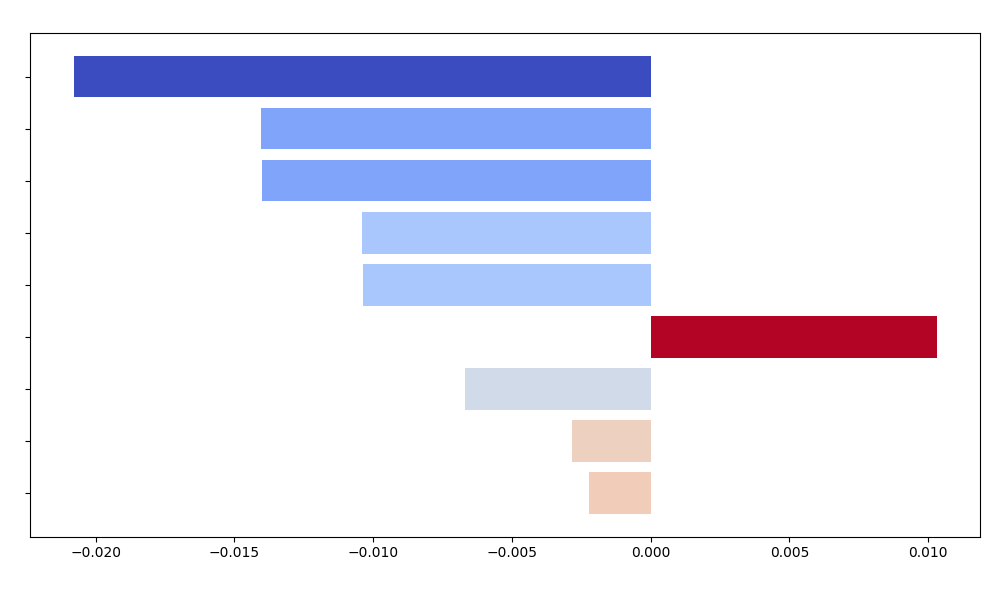

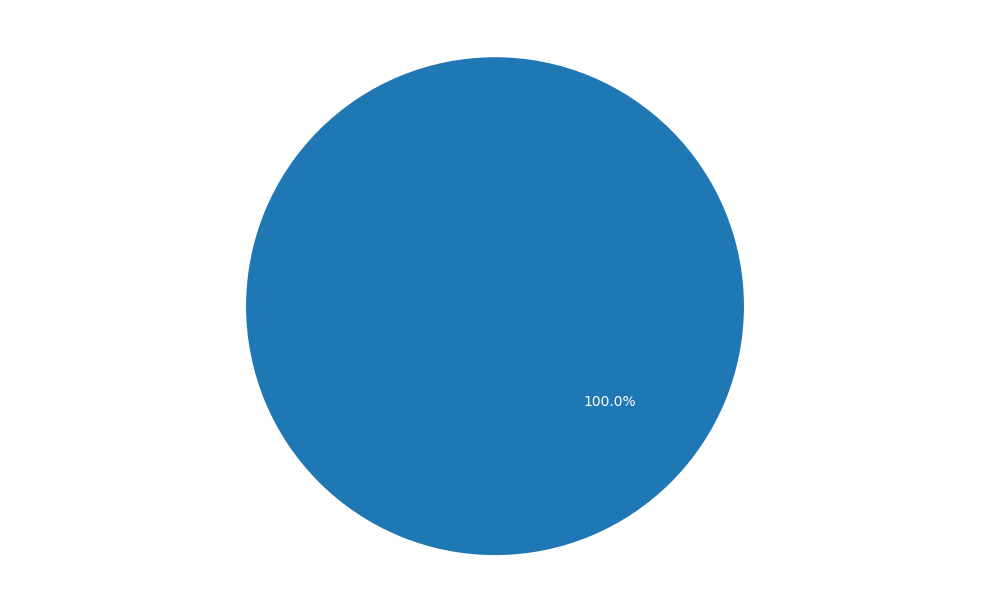

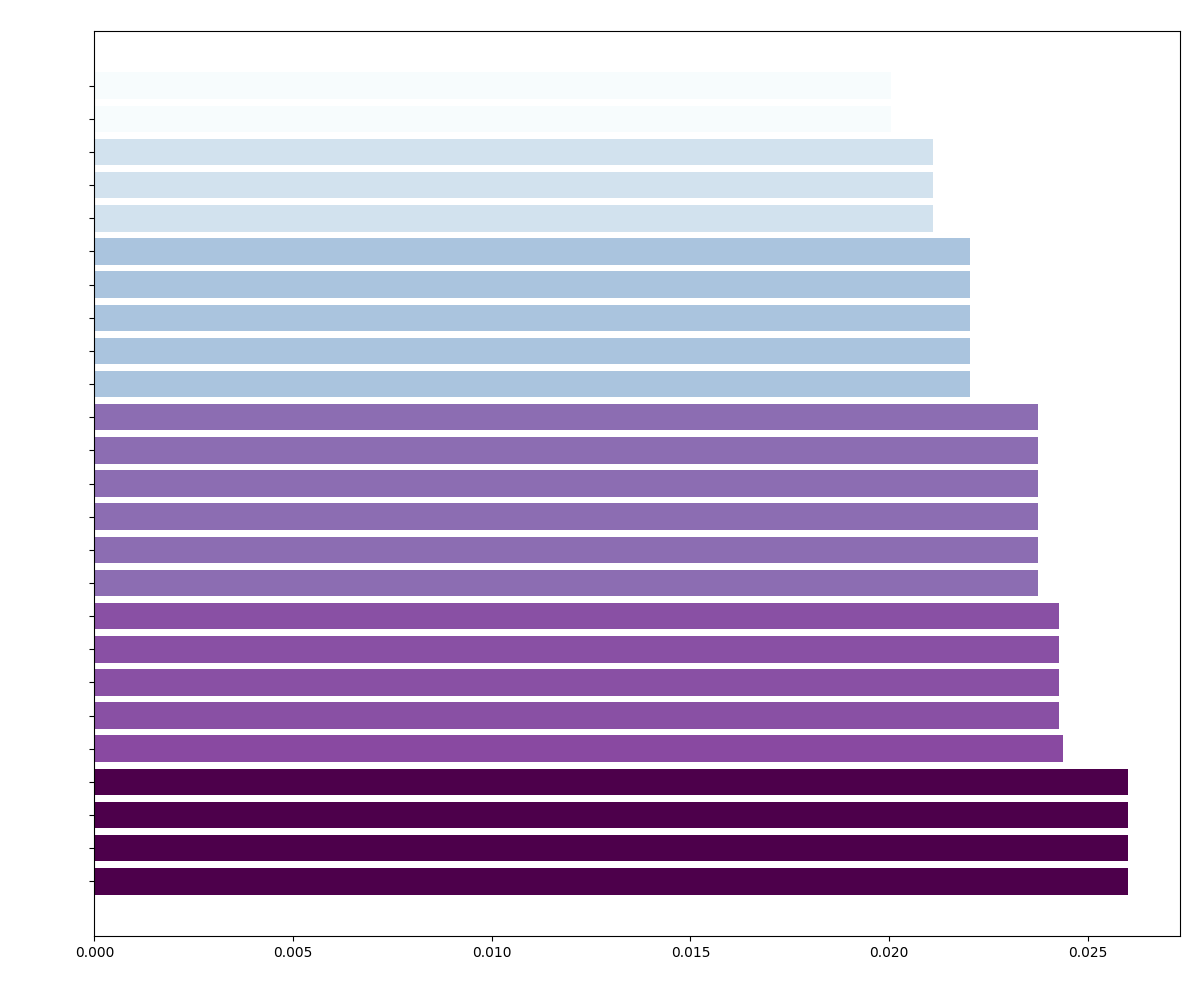

INFO:     connection closed


In [19]:
from fastapi import FastAPI, WebSocket
from fastapi.responses import JSONResponse
import asyncio
import base64
import io
import json
from PIL import Image
import matplotlib.pyplot as plt
import nest_asyncio
import uvicorn

nest_asyncio.apply()

app = FastAPI()

@app.websocket("/shap")
async def websocket_endpoint(websocket: WebSocket):
    await websocket.accept()
    
    try:
        # Recevoir les données d'entrée
        data = await websocket.receive_json()
        description = data['description']
        claim = data['claim']

        # Envoyer JSON "chargement en cours"
        await websocket.send_json({"status": "loading"})

        # Prédire la catégorie
        predicted_categories = predict_category(description, claim, model, tokenizer, mlb)

        # Générer les explications SHAP
        output_dir = 'temp_shap_output'
        explain_prediction_with_shap(description, claim, model, tokenizer, mlb, output_dir)

        # Lire et encoder toutes les images stcokées dans temp_shap_output en base64
        image_files = os.listdir(output_dir)

        # Charger code HTML depuis le fichier minifié
        with open(f"{output_dir}/rendered_minified.f7", "r") as html_file:
            html_content = html_file.read()
        
        encoded_images = {}
        for img_file in image_files:
            with open(f"{output_dir}/{img_file}", "rb") as image_file:
                encoded_string = base64.b64encode(image_file.read()).decode()
                encoded_images[img_file] = encoded_string

        # Préparer la réponse finale
        response = {
            "status": "complete",
            "predicted_categories": predicted_categories[0],
            "shap_images": encoded_images,
            "html_content": html_content
        }

        # Supprimer les images dans temp_shap_output
        for img_file in image_files:
            os.remove(f"{output_dir}/{img_file}")

        # Envoyer la réponse finale
        await websocket.send_json(response)

    except Exception as e:
        await websocket.send_json({"status": "error", "message": str(e)})
    
    finally:
        await websocket.close()

# Lancer le serveur
config = uvicorn.Config(app, host="0.0.0.0", port=8000)
server = uvicorn.Server(config)
await server.serve()